# Proyecto de futbol en inglaterra

In [49]:
%matplotlib inline

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2

In [ ]:
usuario = 'postgres'
password = #insert_tu_contraseña
host = 'localhost'
puerto = '5432'
base_datos = 'futbol'

# Conexión
engine = create_engine(f'postgresql://{usuario}:{password}@{host}:{puerto}/{base_datos}')

# CASO 2
## Análisis de índice ofensivo y defensivo de cada equipo

In [52]:
query = """ WITH partidos AS (
  SELECT 
    p.*, 
    e1.nombre AS home_team,
    e2.nombre AS away_team
  FROM partido p
  JOIN equipo e1 ON p.home_team_id = e1.id
  JOIN equipo e2 ON p.away_team_id = e2.id
  ),
  locales AS (
  SELECT 
    home_team AS team,
    AVG(full_time_home_goals) AS avg_goals_scored,
    AVG(home_shots) AS avg_shots,
    AVG(home_shots_on_target) AS avg_shots_on_target,
    AVG(home_corners) AS avg_corners,
    AVG(full_time_away_goals) AS avg_goals_conceded,
    AVG(away_shots) AS avg_shots_against,
    AVG(away_shots_on_target) AS avg_shots_on_target_against,
    AVG(away_corners) AS avg_corners_against
  FROM partidos
  GROUP BY home_team
  ),
  visitantes AS (
  SELECT 
    away_team AS team,
    AVG(full_time_away_goals) AS avg_goals_scored_away,
    AVG(away_shots) AS avg_shots_away,
    AVG(away_shots_on_target) AS avg_shots_on_target_away,
    AVG(away_corners) AS avg_corners_away,
    AVG(full_time_home_goals) AS avg_goals_conceded_away,
    AVG(home_shots) AS avg_shots_against_away,
    AVG(home_shots_on_target) AS avg_shots_on_target_against_away,
    AVG(home_corners) AS avg_corners_against_away
  FROM partidos
  GROUP BY away_team
  )

  SELECT 
  l.team,

  (l.avg_goals_scored + v.avg_goals_scored_away) / 2 AS avg_goals_scored_total,
  (l.avg_shots + v.avg_shots_away) / 2 AS avg_shots_total,
  (l.avg_shots_on_target + v.avg_shots_on_target_away) / 2 AS avg_shots_on_target_total,
  (l.avg_corners + v.avg_corners_away) / 2 AS avg_corners_total,

  (l.avg_goals_conceded + v.avg_goals_conceded_away) / 2 AS avg_goals_conceded_total,
  (l.avg_shots_against + v.avg_shots_against_away) / 2 AS avg_shots_against_total,
  (l.avg_shots_on_target_against + v.avg_shots_on_target_against_away) / 2 AS avg_shots_on_target_against_total,
  (l.avg_corners_against + v.avg_corners_against_away) / 2 AS avg_corners_against_total,

  (
    ((l.avg_goals_scored + v.avg_goals_scored_away) / 2) * 3 +
    ((l.avg_shots_on_target + v.avg_shots_on_target_away) / 2) * 2 +
    ((l.avg_shots + v.avg_shots_away) / 2) +
    ((l.avg_corners + v.avg_corners_away) / 2)
  ) AS attack_index,

  (
    10 - (
      ((l.avg_goals_conceded + v.avg_goals_conceded_away) / 2) * 3 +
      ((l.avg_shots_on_target_against + v.avg_shots_on_target_against_away) / 2) * 2 +
      ((l.avg_shots_against + v.avg_shots_against_away) / 2) +
      ((l.avg_corners_against + v.avg_corners_against_away) / 2)
    )
  ) AS defense_index

  FROM locales l
  JOIN visitantes v ON l.team = v.team
  ORDER BY attack_index DESC;
"""
df = pd.read_sql(query, engine)


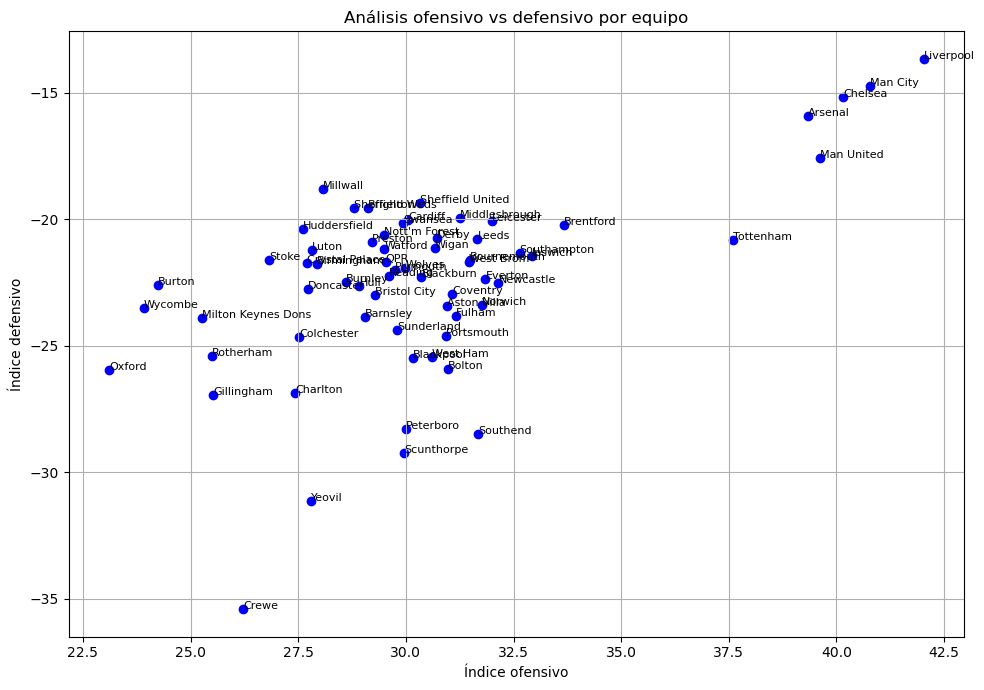

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df['attack_index'], df['defense_index'], color='blue')

for i, row in df.iterrows():
    plt.text(row['attack_index'], row['defense_index'], row['team'], fontsize=8)

plt.title("Análisis ofensivo vs defensivo por equipo")
plt.xlabel("Índice ofensivo")
plt.ylabel("Índice defensivo")
plt.grid(True)
plt.tight_layout()
plt.show()

## Partidos ganados x -- SQL

In [54]:

consulta = '''WITH parts AS (
  SELECT 
    p.*, 
    e1.nombre AS home_team,
    e2.nombre AS away_team
  FROM partido p
  JOIN equipo e1 ON p.home_team_id = e1.id
  JOIN equipo e2 ON p.away_team_id = e2.id
),
partidos AS (
  SELECT 
    date,
    home_team AS team,
    away_team AS opponent,
    full_time_home_goals AS goals_for,
    full_time_away_goals AS goals_against,
    home_shots AS shots,
    home_shots_on_target AS shots_on_target,
    home_corners AS corners,
    CASE 
      WHEN full_time_result = 'H' THEN 1
      WHEN full_time_result = 'D' THEN 0.5
      ELSE 0
    END AS won,
    CASE 
      WHEN home_shots_on_target > away_shots_on_target AND home_corners > away_corners THEN 0.9  
      WHEN home_shots > away_shots THEN 0.8  
      WHEN home_shots_on_target > away_shots_on_target THEN 0.7  
      ELSE 0.5  
    END AS expected_win
  FROM parts

  UNION ALL

  SELECT 
    date,
    away_team AS team,
    home_team AS opponent,
    full_time_away_goals AS goals_for,
    full_time_home_goals AS goals_against,
    away_shots AS shots,
    away_shots_on_target AS shots_on_target,
    away_corners AS corners,
    CASE 
      WHEN full_time_result = 'A' THEN 1
      WHEN full_time_result = 'D' THEN 0.5
      ELSE 0
    END AS won,
    CASE 
      WHEN away_shots_on_target > home_shots_on_target AND away_corners > home_corners THEN 0.8  
      WHEN away_shots > home_shots THEN 0.7  
      WHEN away_shots_on_target > home_shots_on_target THEN 0.6  
      ELSE 0.0  
    END AS expected_win
  FROM parts
)

SELECT 
  team,
  COUNT(*) AS matches,
  ROUND(SUM(won), 2) AS real_points,
  ROUND(SUM(expected_win), 2) AS expected_points,
  ROUND(SUM(won) - SUM(expected_win), 2) AS overperformance
FROM partidos
GROUP BY team
ORDER BY overperformance DESC;
 '''


/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_44812/2896607425.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overperformance', y='team', data=df.sort_values('overperformance'), palette='viridis')


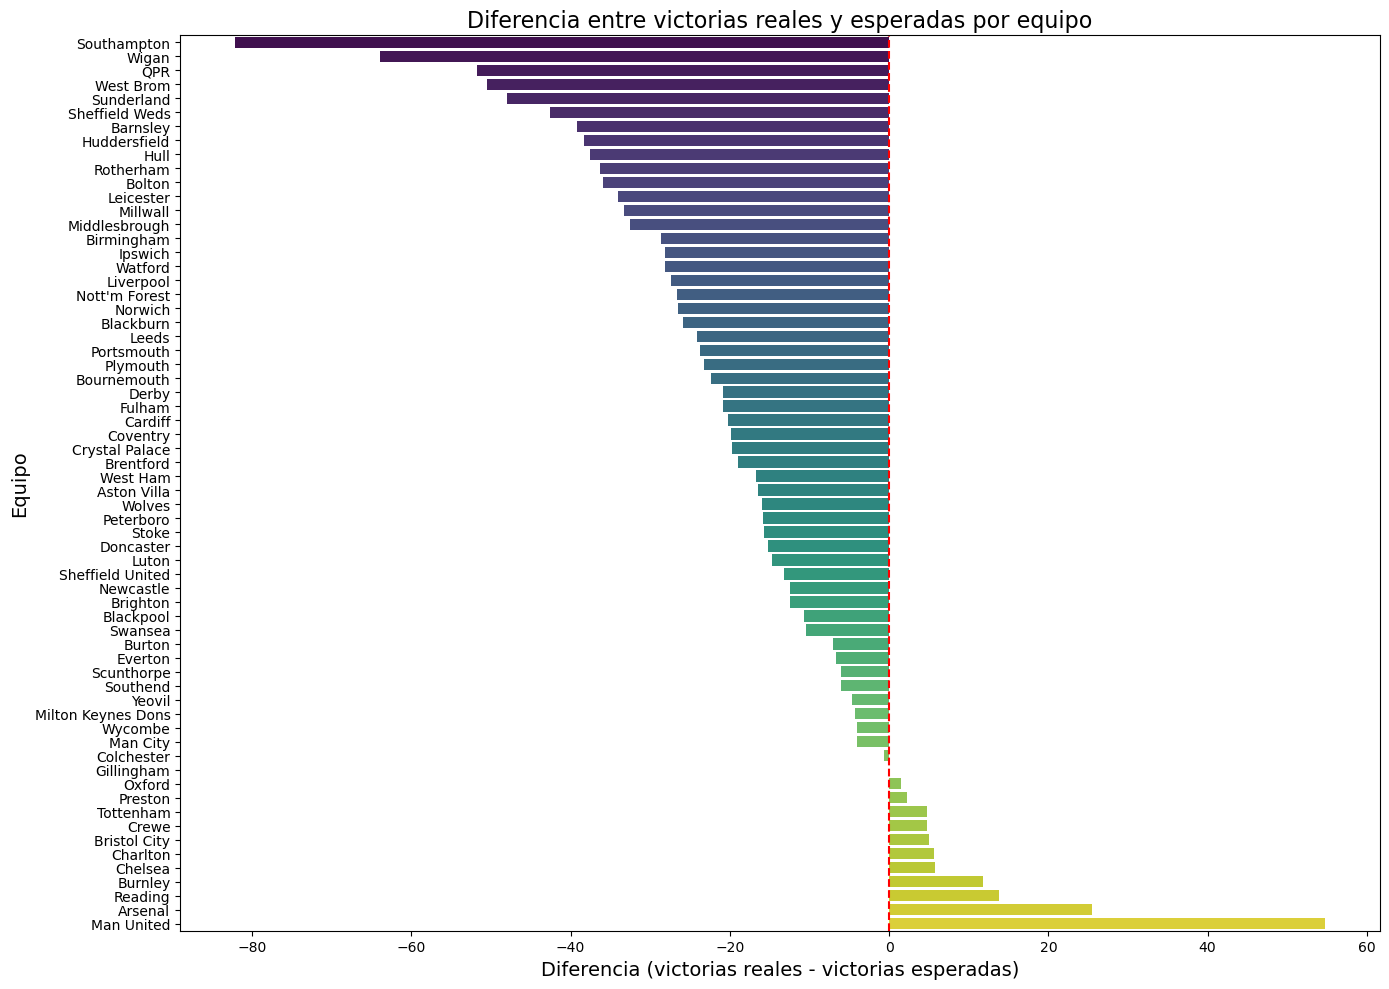

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Consulta SQL (asegúrate de ejecutarla y obtener el DataFrame)
df = pd.read_sql(consulta, engine)

# Gráfico de barras más grande
plt.figure(figsize=(14, 10))  # Aumento de tamaño de la figura

# Barra con mayor contraste de colores
sns.barplot(x='overperformance', y='team', data=df.sort_values('overperformance'), palette='viridis')

# Línea para señalar la diferencia cero
plt.axvline(0, color='red', linestyle='--')

# Título y etiquetas mejoradas
plt.title("Diferencia entre victorias reales y esperadas por equipo", fontsize=16)
plt.xlabel("Diferencia (victorias reales - victorias esperadas)", fontsize=14)
plt.ylabel("Equipo", fontsize=14)

# Ajuste para mayor visibilidad
plt.tight_layout()

# Mostrar la gráfica
plt.show()



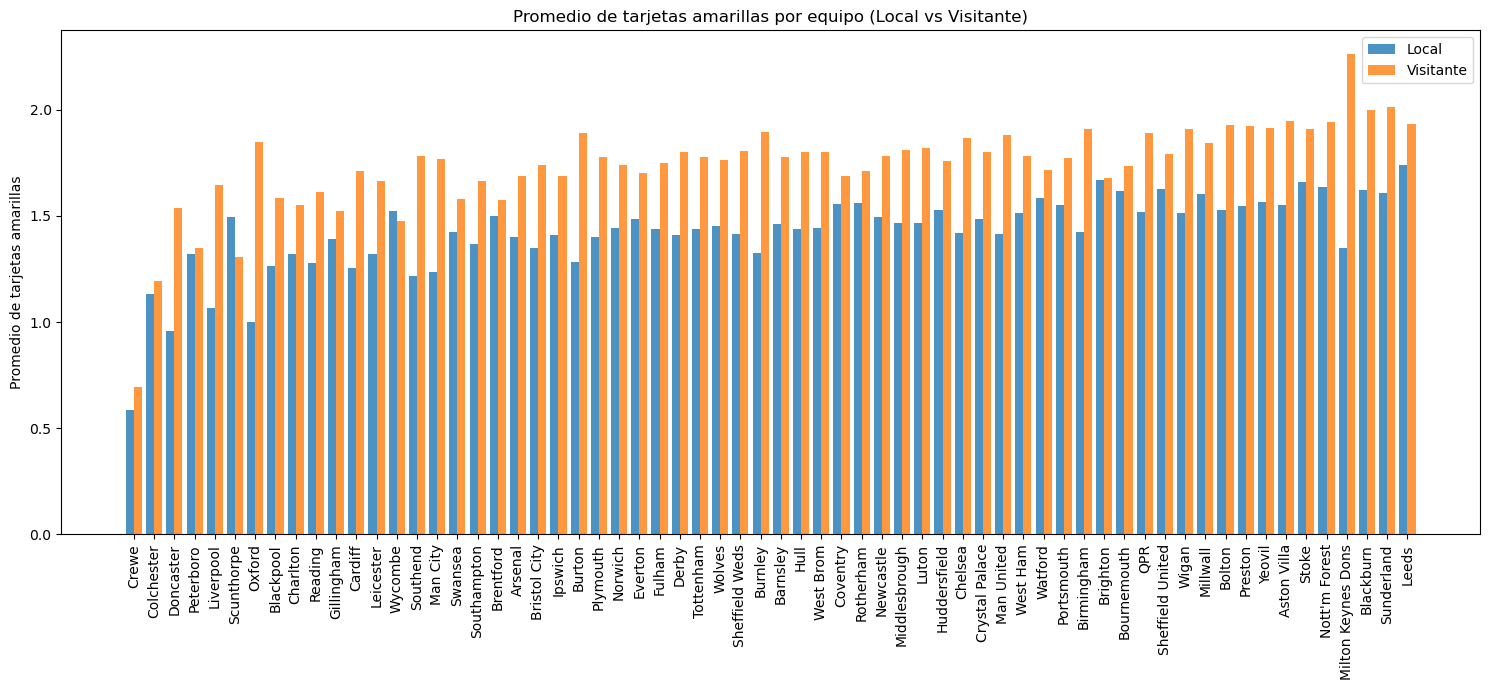

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as psy
import numpy as np


def obtener_promedios_tarjetas():

    query = """
    WITH partidos AS (
        SELECT 
            p.*, 
            e1.nombre AS home_team,
            e2.nombre AS away_team
        FROM partido p
        JOIN equipo e1 ON p.home_team_id = e1.id
        JOIN equipo e2 ON p.away_team_id = e2.id
    )
    SELECT 
	COALESCE(home_team, away_team) AS equipo,
	AVG(home_yellow) AS promedio_amarillas_local,
	AVG(away_yellow) AS promedio_amarillas_visitante,
    COALESCE(AVG(home_yellow), 0) + COALESCE(AVG(away_yellow), 0) AS total
    FROM (
   	SELECT home_team, NULL AS away_team, home_yellow, NULL AS away_yellow
    FROM partidos
    UNION ALL
    SELECT NULL AS home_team, away_team, NULL AS home_yellow, away_yellow
    FROM partidos
    ) sub
    GROUP BY equipo
    ORDER BY total ASC;
    """
    df = pd.read_sql(query, engine)
    return df

# Obtener datos procesados desde SQL
df_promedios = obtener_promedios_tarjetas()

if df_promedios is not None:
    x = np.arange(len(df_promedios))
    width = 0.4

    plt.figure(figsize=(15, 7))
    plt.bar(x - width/2, df_promedios["promedio_amarillas_local"], width=width, label="Local", alpha=0.8)
    plt.bar(x + width/2, df_promedios["promedio_amarillas_visitante"], width=width, label="Visitante", alpha=0.8)

    plt.xticks(ticks=x, labels=df_promedios["equipo"], rotation=90)
    plt.ylabel("Promedio de tarjetas amarillas")
    plt.title("Promedio de tarjetas amarillas por equipo (Local vs Visitante)")
    plt.legend()
    plt.tight_layout()
    plt.show()